# <center> Eddy Overturning StreamFunctions </center> 

In [14]:
# Some parameters
VAR = 'PsiEd'  # Pick what plot
Full = 'Extremes'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'
Qplot = 'Y'

In [15]:
# Load in Modules
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
#import glob
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
%matplotlib inline

if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ']

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'


# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/'+Year
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/3daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
Zmatrix = np.zeros((len(Z), len(Y)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
dzc = Z[0:len(Z)-1]-Z[1:len(Z)]
ny = len(Y)
nz = len(Z)

In [16]:
# Surface Heat Fluxes
Ly = 2000e3
Lx = 1000e3
nx = np.round(Lx/dx)
ny = np.round(Ly/dx)
Q_0 = 10
Q = np.zeros_like(Yc)
pi = math.pi
Q=np.zeros(np.shape(Q))
Q[0:int(5*ny/36)] = Q_0*(np.cos(Yc[0:int(5*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((Yc[int(5*ny/36):int(20*ny/36)]-Yc[int(5*ny/36)])*(pi/(Yc[int(15*ny/36)]))))
Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(Yc[0:int(10*ny/36)]*(pi/(Yc[int(10*ny/36)]))))

In [17]:
def STREAM_FRUNCS(Ind):
    i = Ind
    # PSI ISO
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    TH = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    # REGRID:
    psiz = get_psi_iso_z(psi, TH[:,:],Z)
    
    # LOAD DATA
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    
    # Eddy Stream func
    Vzone = 200*VTav*dx
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi2 = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi3 = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi4 = np.pad(psi3, pad_width=npad, mode='constant', constant_values=0)
    psiz = np.pad(psiz, pad_width=npad, mode='constant', constant_values=0)
    Psi = psi  # Convert to Sv
    Psi2 = psi4/10**6
    Psied = psiz - Psi2
    return psiz, Psied, Psi2

def forcing_top_plot():
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    return gs

def Heat_Fluxes(Ind):
    i = Ind
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = (numba_regridy(VTTav) - numba_regridy(VTav)*TTav)
    WpTp = numba_regridz(WTTav) - numba_regridz(WTav)*TTav
    return TTav, VTav,  WTav, VTTav, WTTav, VpTp, WpTp

def PLOT_IT(ax,ax2,Y,Z,TTav,Q2_levs):
    q = ax.contour(Yc/1000, Z/1000, TTav, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    q = ax2.contour(Yc/1000, Z/1000, TTav, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    return

def Tidy_plot(ax,ax2,i):
    ax.set_title('ROC - MEAN '+str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title('ROC - MEAN '+str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax2.set_xlabel('Distance (km)', fontsize=30)
    ax2.set_ylabel('Depth (km)', fontsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=30)
    return

def fin_plot():
    cax = fig.add_axes([1, 0.1, 0.03, 0.8])
    cbar = fig.colorbar(p, cax=cax, ticks=Eddy_ticks)
    cbar.ax.set_ylabel('$\psi $ (Sv)', fontsize=30)
    cbar.ax.tick_params(labelsize=30)
    return

In [18]:
def put_to_layers(PSISO, Th, Z, depth=2985):
    """Put the output from psi_iso into Z coordinates."""

    # figure out the depth of each layer
    h = Th
    ZFF = np.zeros((300))
    for kk in range(len(Z)-1):
        ZFF[10*kk:10*kk+10] = np.linspace(Z[kk],Z[kk+1],10)
    ZFF[-10::] = np.linspace(Z[-1],Zp[-1],10)
    # psi_iso is defined at the *bottom* of each layer,
    # therefore we want the depth at the bottom of the layer
    z = np.cumsum(h, axis=0) - depth
    # interpolate to center z points
    nz = len(Th[:,1])
    ny = len(Th[1,:])
    psi_iso_z = zeros((nz,ny))
    for j in arange(ny-1):
        VTavff=interp(ZFF,Z[::-1], PSISO[::-1,j])
        psi_iso_z[:,j] = interp(z[:,j], ZFF[::-1],VTavff[::-1])
    return psi_iso_z

# Remap $\overline{VT}$ into T-space

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:79: RuntimeWarning: divide by zero encountered in divide


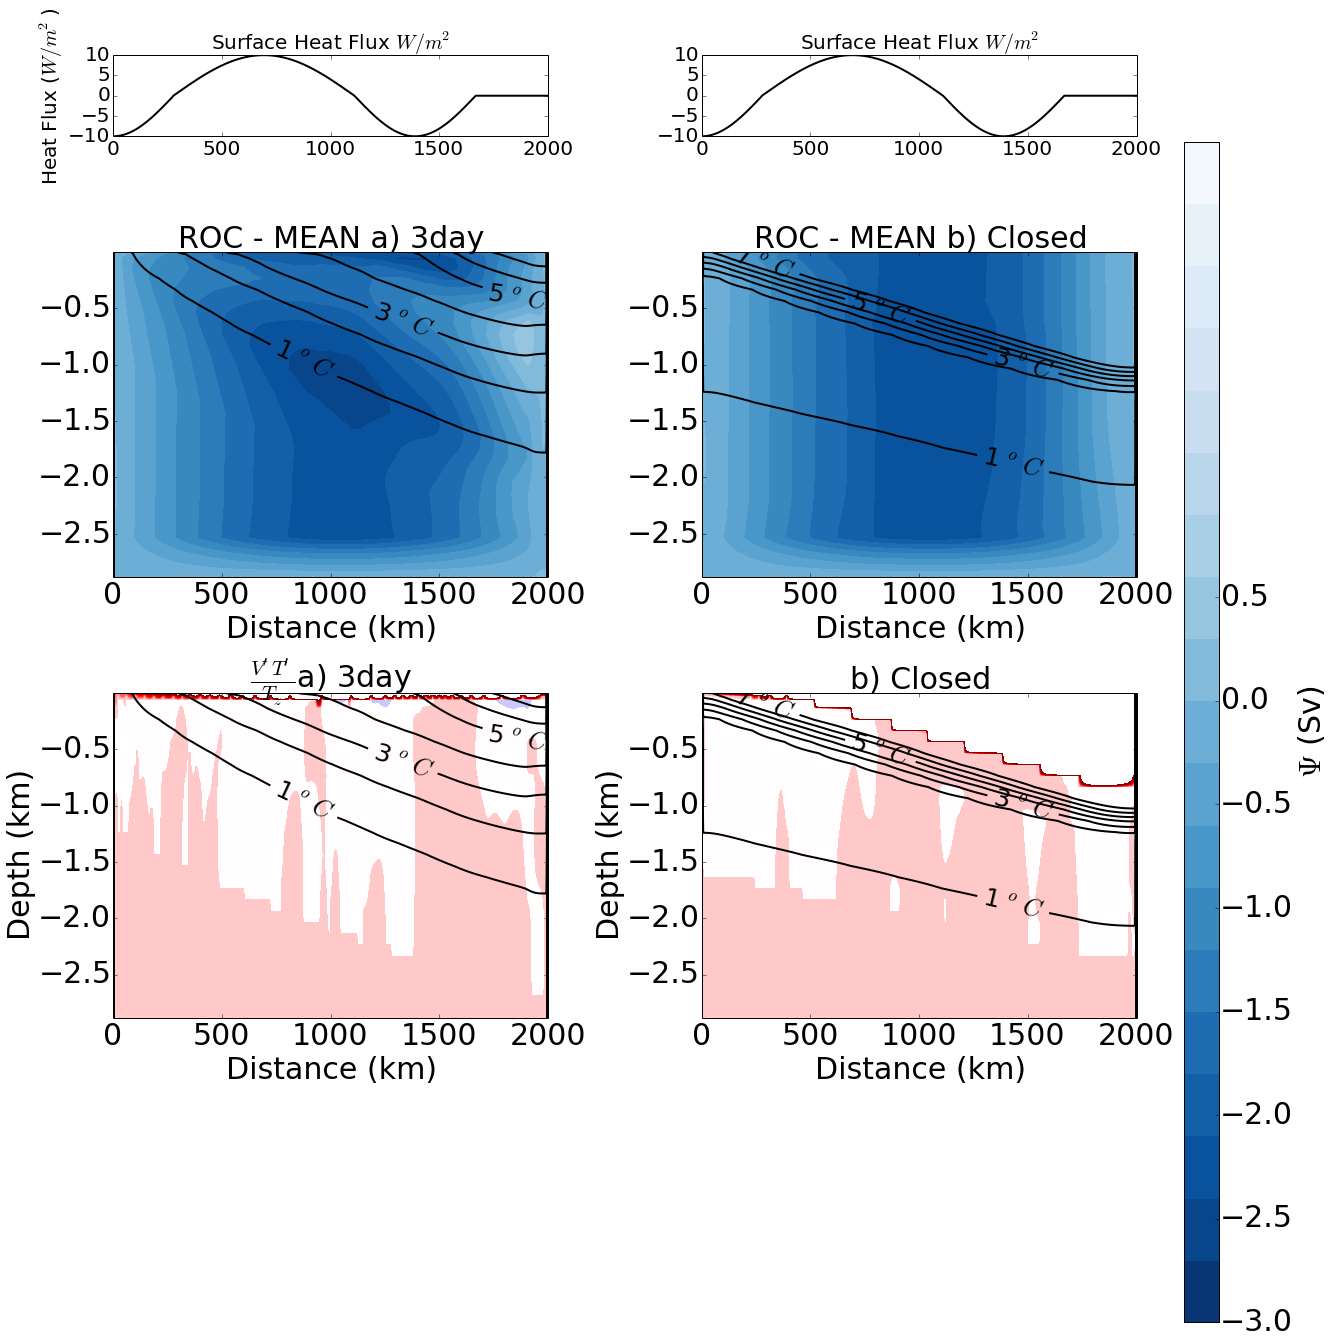

In [43]:
fig = plt.figure(figsize=(16.5, 20.5))
Psi_levs = np.arange(-2., 2., .21)
Psi_ticks =np.arange(-2., 2., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
P_levs = np.arange(-3,3,0.3)
if Qplot == 'Y':
    gs = gridspec.GridSpec(4, 2, height_ratios=[1, 4, 4,4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'+Year
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = numba_regridy(VTfdz)
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    psiz = get_psi_iso_z(psi, th[0:-1,:],Z)
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    nolayers = len(lvrho[1,:, 1])
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(th),np.diff(Rho)[0:nolayers] )
    Rho_matrix2 = np.apply_along_axis(np.multiply,0,ones_like(th),Rho[0:nolayers] )
    Rho = Rho[0:nolayers] 
    
    A = x+'/'+str(tau[Runs[i]])+'daynokpp/Tav.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    # Mean Overturning for Eddy Streamfuction
    V = file2.variables['VVEL'][:]
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave*dx, axis=2)
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi_m = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi_m = np.cumsum(-psi_m[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi_m = np.pad(psi_m, pad_width=npad, mode='constant', constant_values=0)
    # Eddy
    Psied = psiz - numba_regridz(psi_m)/10**6
    Tz = ddz_cgrid_centered(TTav, Z)
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    T_Y = zeros_like(Rho_matrix)
    for zz in range(len(Rho_matrix[:,1])):
        if all(th[zz,:]==0):
            a = 400
        else:
            a = (nonzero(th[zz,:]))[0][-1]
        T_Y[zz,:] = Rho_matrix[zz,0]/(a*dx)
    Vlayer = put_to_layers(VTav[:,:],th,Z)*Rho_matrix2 # VtavTtav
    VTlayer = put_to_layers(VTTav[:,:],th,Z)
    VpTplayer = VTlayer-Vlayer
   
    Ty = numba_regridy(get_psi_iso_z(T_Y, th,Z))
    T_Z = (Rho_matrix/th)
    T_Z[abs(T_Z)<0.002] = 0.002 
    PsiEd = VpTplayer/T_Z
    #Tz = numba_regridy(get_psi_iso_z(T_Z, th,Z))
    #ED = put_to_layers(VpTp[:,:],th[:,:],Z[:])/(T_Z)*200*dx/10**6
    ED = get_psi_iso_z(Vlayer/T_Z,th,Z)
    # PLOT
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(Y/1000, Z/1000,
                    Psied, P_levs, cmap=plt.cm.Blues_r)
    ax2 = plt.subplot(gs[4+i])
    p2 = ax2.contourf(Y/1000, Z/1000,
                  ED  ,P_levs, cmap=plt.cm.seismic)
    q = ax.contour(Yc/1000, Z/1000, TTav, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    q = ax2.contour(Yc/1000, Z/1000, TTav, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title('ROC - MEAN '+str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title('ROC - MEAN '+str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax2.set_title(r'$\frac{V^\prime T^\prime}{T_z}$'+str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax2.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax2.set_xlabel('Distance (km)', fontsize=30)
    ax2.set_ylabel('Depth (km)', fontsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()

# Colorbar
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Eddy_ticks)
cbar.ax.set_ylabel('$\Psi $ (Sv)', fontsize=30)
cbar.ax.tick_params(labelsize=30)